# Notebook for `HDDM_docker`

Author: Hu Chuan-Peng (PhD) @Nanjing Normal University
E-mail: hcp4715@hotmail.com


This is a supplementary notebook for the introductary paper *HDDM_docker: A docker image for reproducible Bayesian hierarchical drift-diffusion modelling*. 

In this notebook, we will demostrate how to conduct HDDM analysis with docker image [`hcp4715/hddm:tutorial`](https://hub.docker.com/r/hcp4715/hddm/tags).

## Loading modules/packages

In [1]:
%matplotlib inline

# General packages for system, time, etc
import os, time, csv, sys
import datetime
from datetime import date
import glob
import feather  # for compiling files

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

# parallel processing related
from p_tqdm import p_map
from functools import partial

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


The current HDDM version is:  0.8.0
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.11.4


####  Import func for converting HDDM objects to `InferenceData`

The scripts are stored at the `scripts` folder, which need to be added to the path temporarily.

In [2]:
# add `script` to the python path so that we can import the scripts
# scripts_dir = os.path.join(os.path.dirname(os.getcwd()), 'scripts')
scripts_dir = '/home/jovyan/examples/scripts'
sys.path.append(scripts_dir)

from HDDMarviz import HDDMarviz
from plot_ppc_by_cond import plot_ppc_by_cond

#### Load the example data Cavanaght et al. (2011)

In [3]:
data_cavanagh = hddm.load_csv(os.path.join(os.path.dirname(hddm.__file__), 
                                           'examples', 
                                           'cavanagh_theta_nn.csv'))
data_cavanagh.tail()

,subj_idx,stim,rt,response,theta,dbs,conf
3983,13,LL,1.450,0.0,-1.237166,0,HC
3984,13,WL,0.711,1.0,-0.377450,0,LC
3985,13,WL,0.784,1.0,-0.694194,0,LC
3986,13,LL,2.350,0.0,-0.546536,0,HC
3987,13,WW,1.250,1.0,0.752388,0,HC


## Model fitting

Here we will fit the data with several models. 

### Define model functions for parallel processing

Here we defined six models, from the simplest DDM to full DDM to regression models.

`ms0`: The simplest model, which do not take account of any variable and fit the data with simple DDM (4 parameters only), and with a hierarchical structure.

`ms1`: The second simplest model, which do not take account of any variable, but fit the data with a full DDM (7 parameters), with a hierarchical structure.

In [4]:
%%time

# M0_0: base model: simplified
def ms0(id, df=None, samples=None, burn=None, thin=1, save_name="ms0"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df)
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M1: base model: full model
def ms1(id, df=None, samples=None, burn=None, thin=1, save_name="ms1"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'sz', 'st'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M2: treat within-subj as between-subj: full model
def ms2(id, df=None, samples=None, burn=None, thin=1, save_name="ms2"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id    
    m = hddm.HDDM(df, include=['z', 'sv', 'st', 'sz'], 
                  depends_on={'v': 'conf'})
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m


# M3: regression model (varying intercept)
def ms3(id, df=None, samples=None, burn=None, thin=1, save_name="ms3"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,  
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=True,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M4: regression model (varying intercept and slope)
def ms4(id, df=None, samples=None, burn=None, thin = 1, save_name="ms4"): 
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id   
    m = hddm.HDDMRegressor(df,
                           "v ~ C(conf, Treatment('LC'))", 
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, thin=thin, dbname=dbname, db='pickle')
    m.save(mname)
    
    return m

# M5: Regression for both parameters
def ms5(id, df=None, samples=None, burn=None, thin=1, save_name="ms5"):
    print('running chain {:d} for model {}'.format(id, save_name))
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    a_reg = {'model': "a ~ theta:C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    v_reg = {'model': "v ~ C(conf, Treatment('LC'))", 'link_func': lambda x: x}
    reg_descr = [a_reg, v_reg]
    
    m = hddm.HDDMRegressor(df,
                           reg_descr,
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                           include=['z', 'sv', 'st', 'sz'])
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, thin=thin, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 9.54 µs


### Work with a single model

Here we can work with only one model.

`HDDMarviz` will save the model objects and the InferenceData separately. The name of model object will be `'function name' + '_' + savetag + chain`, e.g., `ms0_tmp_chain_0`. The file name of the Inference data will be `'function name' + '_' + savetag + '_netcdf'`, e.g., `ms0_tmp_netcdf`

In [5]:
models, InfData = HDDMarviz(data=data_cavanagh, 
                            model_func=ms0,
                            samples=800, 
                            nppc=200, 
                            burn=300, 
                            thin=1, 
                            chains=4, 
                            savefile=True,
                            savetag="tmp")

Inference data  ms0_tmp  already exist, will load model data instead of re-run
current loading:  ms0_tmp_chain_0 

current loading:  ms0_tmp_chain_1 

current loading:  ms0_tmp_chain_2 

current loading:  ms0_tmp_chain_3 



Plot the trace of the model

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

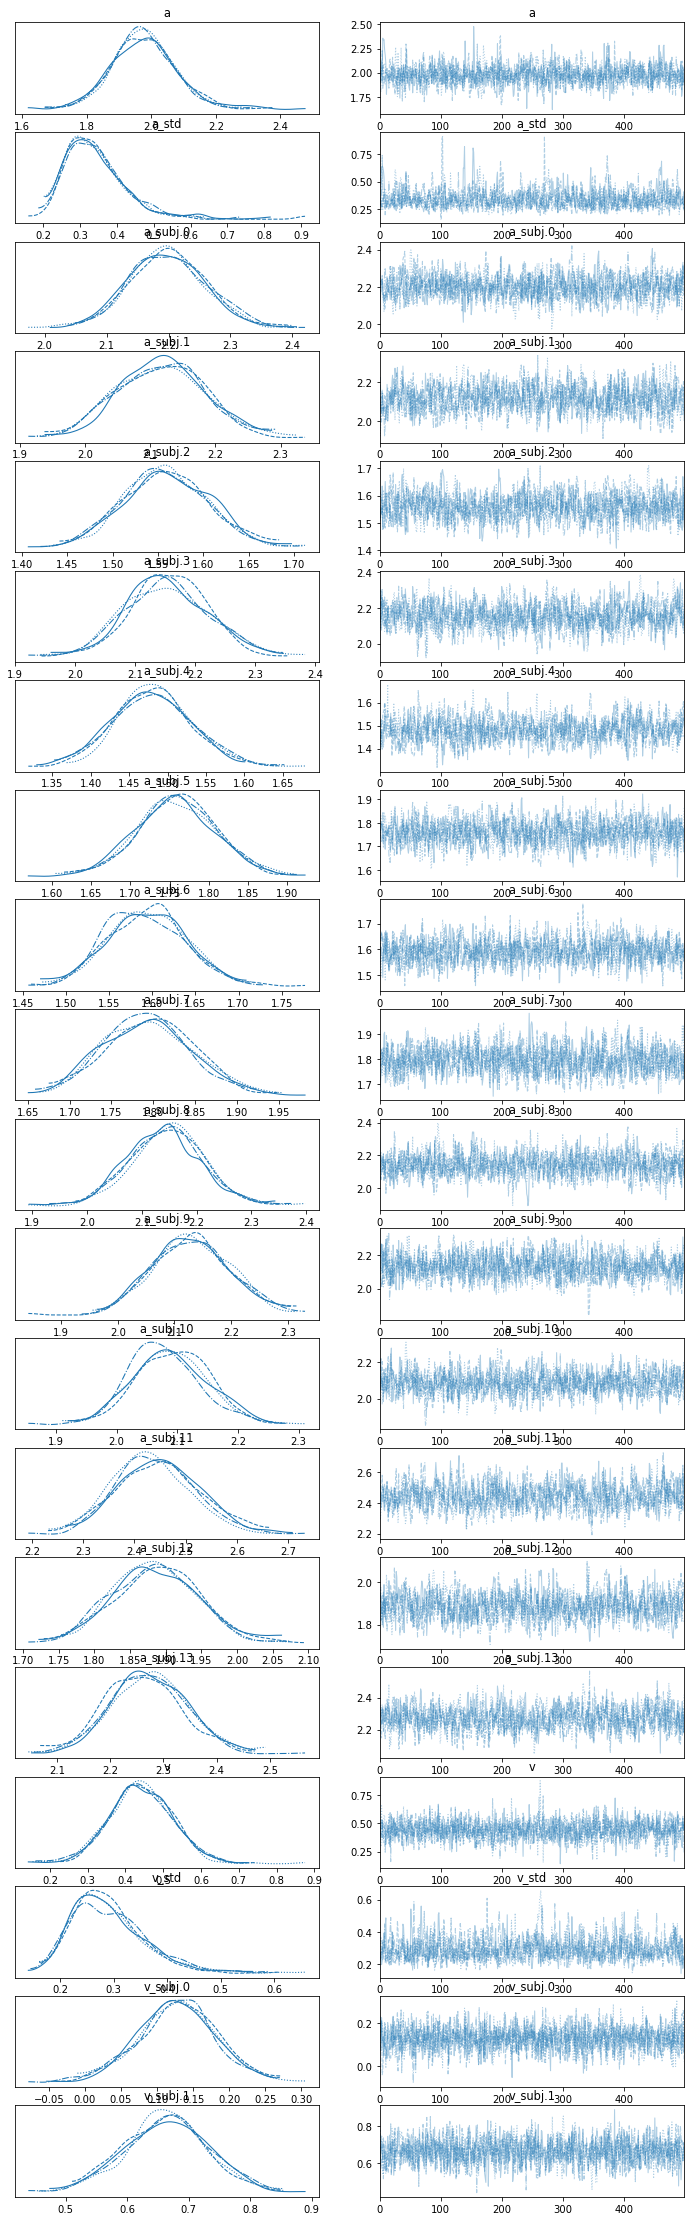

In [6]:
az.plot_trace(InfData)

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

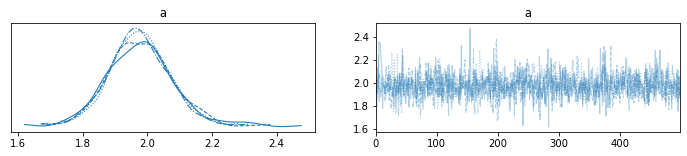

In [7]:
az.plot_trace(InfData, var_names=("^a(?!.*(subj|std))"), filter_vars='regex')

Using `az.summary()` to check $\hat{R}$ and Effective Sample Size (ESS)

In [8]:
ms0_summary = az.summary(InfData)
ms0_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.978,0.100,1.790,2.161,0.002,0.002,1623.0,1185.0,1.00
v_subj.6,0.459,0.079,0.317,0.603,0.002,0.001,1913.0,1631.0,1.00
v_subj.7,0.030,0.069,-0.086,0.169,0.002,0.001,2059.0,1525.0,1.00
v_subj.8,0.493,0.061,0.382,0.612,0.001,0.001,1923.0,1468.0,1.00
v_subj.9,0.224,0.069,0.094,0.354,0.002,0.001,2077.0,1344.0,1.00
v_subj.10,0.570,0.062,0.454,0.688,0.001,0.001,2017.0,1309.0,1.00
v_subj.11,0.589,0.058,0.484,0.702,0.001,0.001,1678.0,1461.0,1.00
v_subj.12,0.617,0.070,0.489,0.749,0.002,0.001,1545.0,1179.0,1.00
v_subj.13,0.216,0.056,0.116,0.330,0.001,0.001,1901.0,1360.0,1.00
t_subj.12,0.400,0.013,0.376,0.425,0.001,0.000,703.0,943.0,1.00


Plot the posterior predictives

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

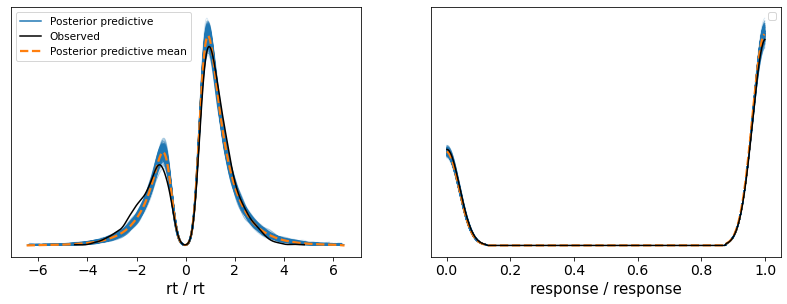

In [9]:
az.plot_ppc(InfData)

In [10]:
az.loo(InfData)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 2000 by 3988 log-likelihood matrix

         Estimate       SE
elpd_loo -10338.35  1513.97
p_loo     4821.10        -

There has been a warning during the calculation. Please check the results.

In [12]:
az.waic(InfData)

Computed from 2000 by 3988 log-likelihood matrix

          Estimate       SE
elpd_waic -37786.93  12074.55
p_waic    32269.68        -

There has been a warning during the calculation. Please check the results.

### Work with multiple models

#### Define arguments for model fitting and converting

Because we are going to compare different models, it's better to make the input arguments the same for all models.

Here, we have a `test_mode` to quickly test the code. If `test_mode` is true, then the samples, burn, number of posterior predictives (nppc) will be relatively small.

In [10]:
test_mode = False

if test_mode:
    samples = 800      # number of MCMC sample; Cavanagh et al.2011 used 30,000
    burn = 300         # number of burn in; Cavanagh et al.2011 used 10,000
    nppc = 200         # number of posterior predictive, super slow
    thin = 1           # thining
    chains = 4         # number of chains, default is 4
    savefile=False     # save file or not, only "True" is available for now.
    savetag = "tmp"    # tag added to saved files.
    model_func = [ms0,
                  ms4] # only test two simple models
else:
    samples = 25000    # number of MCMC sample; Cavanagh et al.2011 used 30,000
    burn = 10000       # number of burn in; Cavanagh et al.2011 used 10,000
    nppc = 5000        # number of posterior predictive, super slow
    thin = 3           # thining
    chains = 4         # number of chains, default is 4
    savefile= True     # save file or not, only "True" is available for now.
    savetag = None     # tag added to saved files.
    model_func = [ms0,
                  ms1,
                  ms2,
                  ms3,
                  ms4,
                  ms5]

#### Fit models and convert to Inference data

In [11]:
%%time
models, InfData = HDDMarviz(data=data_cavanagh, 
                            model_func=model_func,
                            samples=samples, 
                            nppc=nppc, 
                            burn=burn, 
                            thin=thin, 
                            chains=chains, 
                            savefile=savefile,
                            savetag=savetag)

Inference data  ms0  already exist, will load model data instead of re-run
current loading:  ms0_chain_0 

current loading:  ms0_chain_1 

current loading:  ms0_chain_2 

current loading:  ms0_chain_3 

Inference data  ms1  already exist, will load model data instead of re-run
current loading:  ms1_chain_0 

current loading:  ms1_chain_1 

current loading:  ms1_chain_2 

current loading:  ms1_chain_3 

Inference data  ms2  already exist, will load model data instead of re-run
current loading:  ms2_chain_0 

current loading:  ms2_chain_1 

current loading:  ms2_chain_2 

current loading:  ms2_chain_3 

Inference data  ms3  already exist, will load model data instead of re-run
current loading:  ms3_chain_0 

current loading:  ms3_chain_1 

current loading:  ms3_chain_2 

current loading:  ms3_chain_3 

Inference data  ms4  already exist, will load model data instead of re-run
current loading:  ms4_chain_0 

current loading:  ms4_chain_1 

current loading:  ms4_chain_2 

current loading: 

## Bayesian modelling with `ArviZ`

### Model diagnosis

#### Visual inspection

Let's also plot the trace of `ms0`. Using the default settings, it will plot all parameters' trace. We can index each model's InferenceData using name. Here we use the same name as the name of function.

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'a_std'}>,
        <AxesSubplot:title={'center':'a_std'}>],
       [<AxesSubplot:title={'center':'a_subj.0'}>,
        <AxesSubplot:title={'center':'a_subj.0'}>],
       [<AxesSubplot:title={'center':'a_subj.1'}>,
        <AxesSubplot:title={'center':'a_subj.1'}>],
       [<AxesSubplot:title={'center':'a_subj.2'}>,
        <AxesSubplot:title={'center':'a_subj.2'}>],
       [<AxesSubplot:title={'center':'a_subj.3'}>,
        <AxesSubplot:title={'center':'a_subj.3'}>],
       [<AxesSubplot:title={'center':'a_subj.4'}>,
        <AxesSubplot:title={'center':'a_subj.4'}>],
       [<AxesSubplot:title={'center':'a_subj.5'}>,
        <AxesSubplot:title={'center':'a_subj.5'}>],
       [<AxesSubplot:title={'center':'a_subj.6'}>,
        <AxesSubplot:title={'center':'a_subj.6'}>],
       [<AxesSubplot:title={'center':'a_subj.7'}>,
        <AxesSubplot:title={'center':'a_su

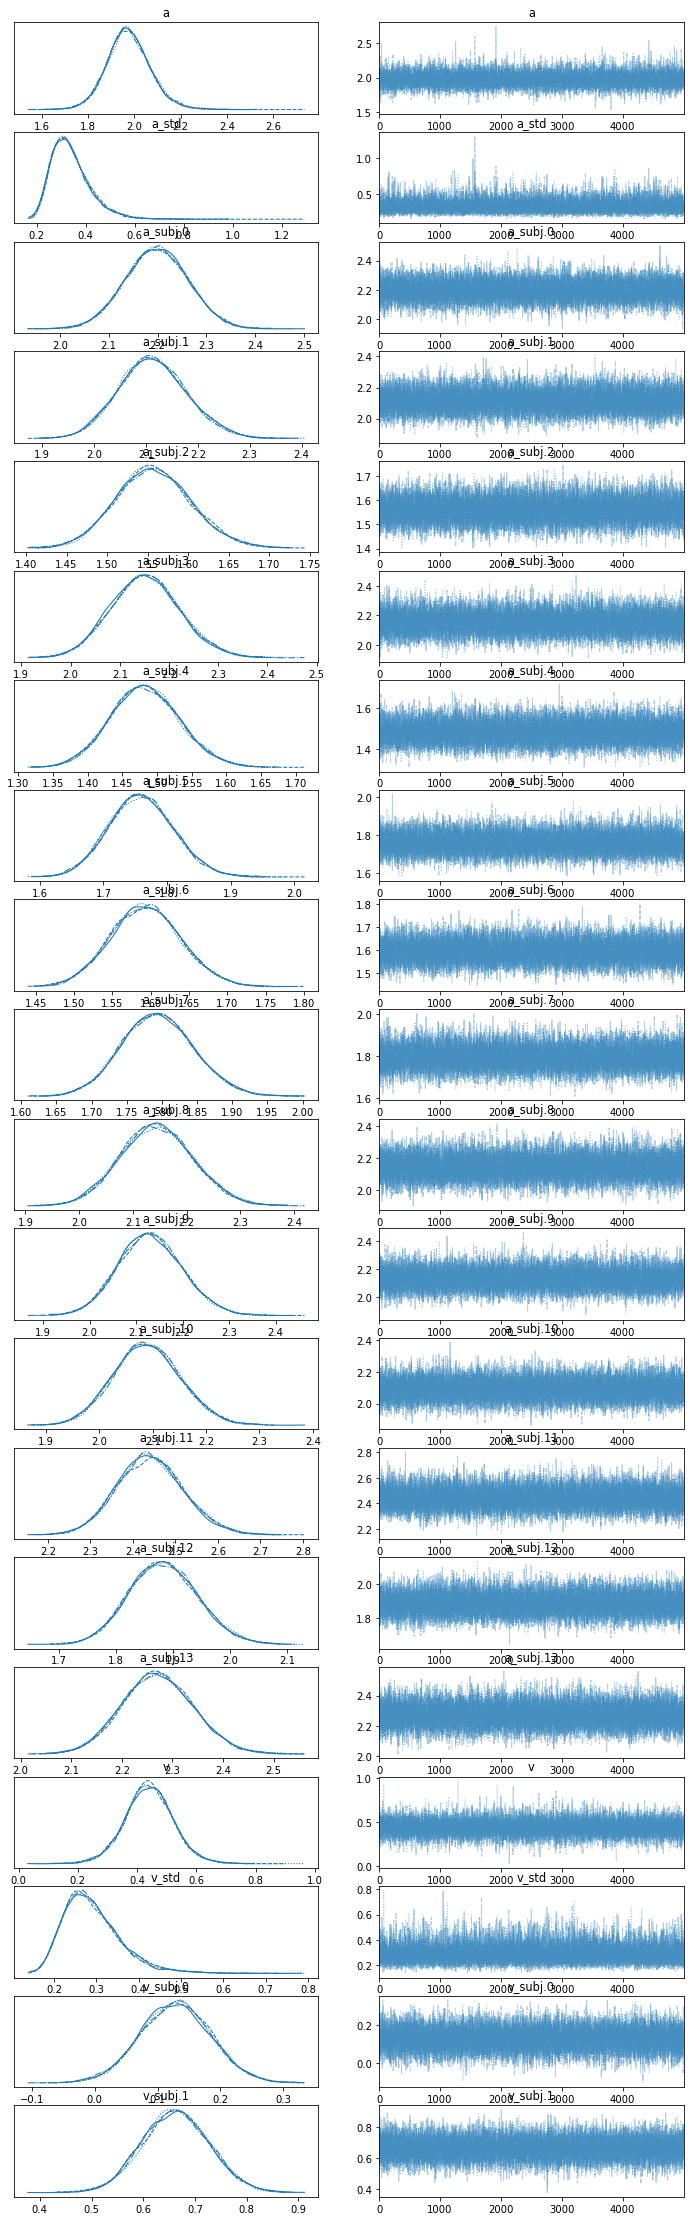

In [12]:
az.plot_trace(InfData['ms0'])

We can also only plot selected parameters' traces. Here we use regex to select var_names that start with "a" and do not contain either "subj" or "std".

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>]], dtype=object)

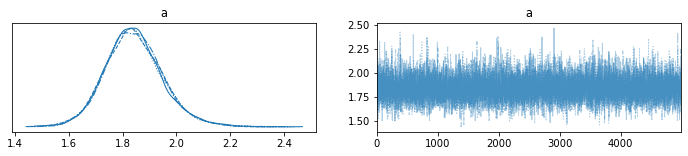

In [13]:
az.plot_trace(InfData['ms4'], var_names=("^a(?!.*(subj|std))"), filter_vars='regex')

#### Using `az.summary()` to check $\hat{R}$ and ESS

In [14]:
ms0_summary = az.summary(InfData['ms0'])
ms0_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.976,0.095,1.798,2.155,0.001,0.0,19213.0,18567.0,1.0
v_subj.8,0.494,0.061,0.376,0.608,0.000,0.0,19847.0,18765.0,1.0
v_subj.9,0.228,0.067,0.105,0.352,0.000,0.0,19409.0,18839.0,1.0
v_subj.10,0.571,0.061,0.457,0.687,0.000,0.0,19362.0,18834.0,1.0
v_subj.11,0.589,0.057,0.485,0.697,0.000,0.0,19695.0,19012.0,1.0
v_subj.12,0.614,0.073,0.473,0.747,0.001,0.0,19355.0,18590.0,1.0
v_subj.13,0.217,0.057,0.112,0.324,0.000,0.0,19685.0,18809.0,1.0
t,0.490,0.033,0.428,0.553,0.000,0.0,19264.0,18964.0,1.0
t_std,0.119,0.028,0.073,0.172,0.000,0.0,18083.0,17462.0,1.0
t_subj.0,0.552,0.030,0.495,0.607,0.000,0.0,17405.0,18716.0,1.0


In [15]:
ms5_summary = az.summary(InfData['ms5'])
ms5_summary.sort_values('r_hat')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
t,0.619,0.035,0.554,0.688,0.000,0.000,7013.0,10496.0,1.00
v_Intercept,0.764,0.114,0.555,0.983,0.001,0.001,9860.0,13255.0,1.00
"a_theta:C(conf, Treatment('LC'))[LC]_subj.13",-0.035,0.038,-0.112,0.037,0.001,0.000,4868.0,11868.0,1.00
"a_theta:C(conf, Treatment('LC'))[LC]_subj.12",-0.021,0.036,-0.087,0.051,0.001,0.000,4016.0,10067.0,1.00
"a_theta:C(conf, Treatment('LC'))[LC]_subj.11",-0.000,0.052,-0.082,0.104,0.001,0.001,2478.0,6066.0,1.00
...,...,...,...,...,...,...,...,...,...
z_subj_trans.9,0.010,0.062,-0.118,0.116,0.001,0.001,2430.0,3289.0,1.00
a_Intercept_subj.4,1.292,0.062,1.174,1.407,0.001,0.000,9891.0,14589.0,1.00
"v_C(conf, Treatment('LC'))[T.HC]_subj.13",-0.454,0.102,-0.634,-0.251,0.001,0.001,7209.0,12127.0,1.00
z_std,0.046,0.030,0.000,0.097,0.001,0.001,876.0,681.0,1.01


### Model comparison and selection

#### DIC

Here we record the DIC of each model in the models and sort by DIC.

In [16]:
%%time

tmp_dic = []
indx_name = []
for m_key, model in models.items():
    m_tmp = kabuki.utils.concat_models(model)
    tmp_dic.append(m_tmp.dic)
    indx_name.append(m_key)
    
comp_dic = pd.DataFrame(tmp_dic, index=indx_name, columns=['dic'])
comp_dic = comp_dic.sort_values(by=['dic'])
comp_dic = comp_dic.reset_index()
comp_dic.rename(columns={'index':'rank'}, inplace=True)
comp_dic

CPU times: user 25 s, sys: 260 ms, total: 25.2 s
Wall time: 25.2 s


,rank,dic
0,ms2,10654.593336
1,ms4,10655.041224
2,ms5,10659.361171
3,ms3,10661.068852
4,ms1,10835.542182
5,ms0,10973.463141


#### PSIS-LOO-CV

In [17]:
comp_loo = az.compare(InfData, ic='loo')
comp_loo

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:927: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:959: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
ms3,0,-8217.364534,2803.038048,0.000000,0.000000e+00,1239.566838,0.000000,True,log
ms5,1,-8218.877424,2822.104267,1.512890,3.931333e-01,1259.186526,53.844649,True,log
ms4,2,-8285.124944,2880.877084,67.760410,4.211000e-01,1288.518035,78.951086,True,log
ms2,3,-8441.107042,3042.074900,223.742508,4.370007e-14,1316.882262,112.575748,True,log
ms1,4,-8511.544589,3010.658658,294.180055,0.000000e+00,1300.387829,94.475340,True,log
ms0,5,-14064.424983,8547.819436,5847.060449,1.857667e-01,2184.144586,2312.932300,True,log


####  WAIC

In [18]:
comp_waic = az.compare(InfData, ic='waic')
comp_waic

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
ms3,0,-11968.359070,6554.032585,0.000000,0.000000e+00,3446.975211,0.000000,True,log
ms5,1,-12281.568567,6884.795411,313.209497,1.809434e-01,3648.263876,209.914287,True,log
ms4,2,-12332.088523,6927.840663,363.729453,4.417425e-01,3628.362832,338.308889,True,log
ms1,3,-12392.571819,6891.685888,424.212748,6.784156e-15,3537.026033,208.844418,True,log
ms2,4,-12553.950451,7154.918309,585.591381,1.767997e-01,3791.614665,409.500866,True,log
ms0,5,-39581.817561,34065.212014,27613.458491,2.005143e-01,12569.237072,12975.375095,True,log


#### Posterior predictive check

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

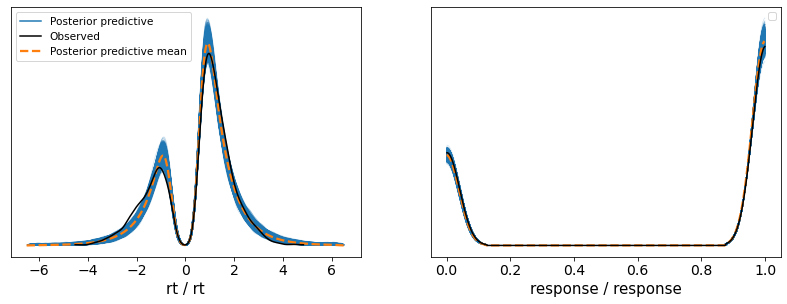

In [19]:
az.plot_ppc(InfData['ms0'])

array([<AxesSubplot:xlabel='rt / rt'>,
       <AxesSubplot:xlabel='response / response'>], dtype=object)

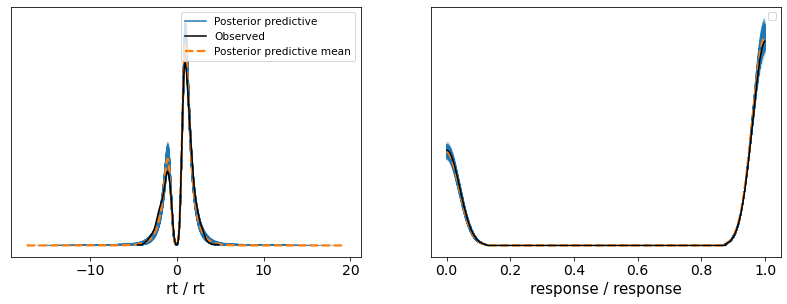

In [20]:
az.plot_ppc(InfData['ms4'])

[3, 'HC', 1]
[3, 'LC', 1]
[3, 'LC', 0]
[3, 'HC', 0]


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_1'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_1'>],
       [<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_0'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_0'>]],
      dtype=object)

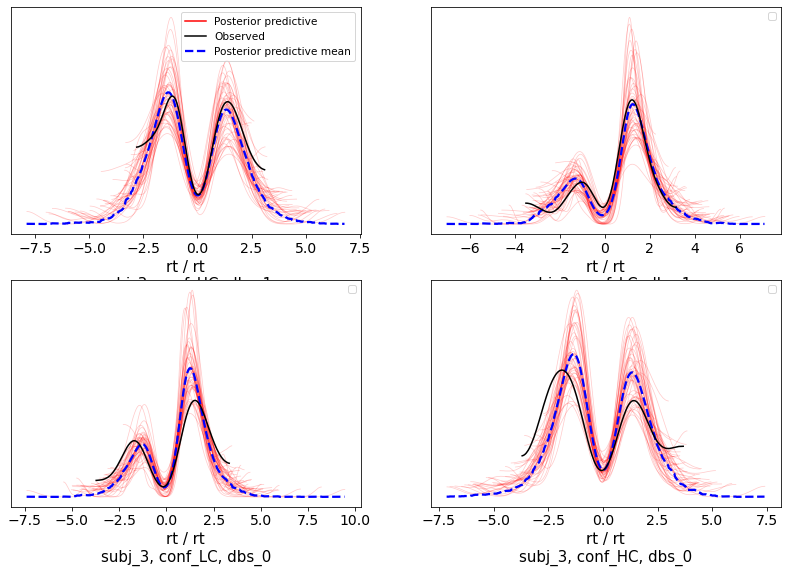

In [21]:
plot_ppc_by_cond(data = InfData['ms5'],
                 or_d = data_cavanagh,
                 subjs = [3],
                 conds = ['conf','dbs'],
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=100,
                 random_seed = 7,
                 alpha = 0.2,
                 grid = [2,2],
                 var_names=['rt'])

[3, 'HC', 1]
[3, 'LC', 1]
[3, 'LC', 0]
[3, 'HC', 0]


array([[<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_1'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_1'>],
       [<AxesSubplot:xlabel='rt / rt\nsubj_3, conf_LC, dbs_0'>,
        <AxesSubplot:xlabel='rt / rt\nsubj_3, conf_HC, dbs_0'>]],
      dtype=object)

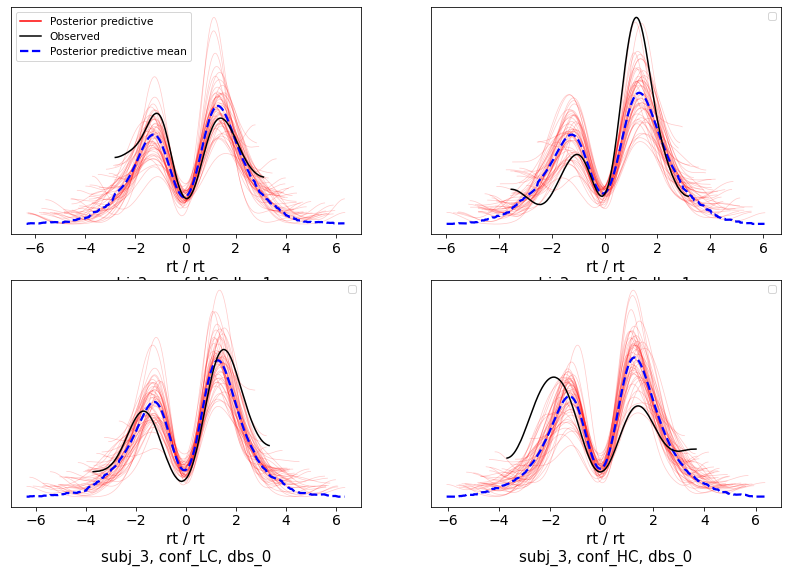

In [22]:
plot_ppc_by_cond(data = InfData['ms0'],
                 or_d = data_cavanagh,
                 subjs = [3],
                 conds = ['conf','dbs'],
                 colors = ['r', 'k', 'b'],
                 num_pp_samples=100,
                 random_seed = 7,
                 alpha = 0.2,
                 grid = [2,2],
                 var_names=['rt'])

## Statistical Inference

Here we onlyu examplified how to us ROPE + HDI method. Assume that we are interested in the effect of conflit level on drift rate `v` and we used [-0.2, 0.2] as the ROPE. Then we can used visualize the ROPE and HDI with `az.plot_posterior()`.

<AxesSubplot:title={'center':"v_C(conf, Treatment('LC'))[T.HC]"}>

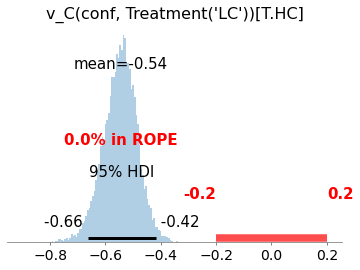

In [23]:
# using regex to select var_names that start with "a_theta" and do not contain either "subj" or "std"
az.plot_posterior(InfData['ms4'], 
                  var_names=("^v_(?!.*(subj|std|Intercept))"), 
                  filter_vars='regex',
                  # grid = [2, 2], 
                  kind = 'hist',
                  hdi_prob = 0.95,
                  rope = [-0.2, 0.2], # assume this is our ROPE
                  rope_color = 'r')